# PrimaCare AI - Prototype

**MedGemma Impact Challenge** - Working Prototype

Complete diagnostic support system combining MedGemma + MedSigLIP.

**Requirements:**
- Kaggle GPU (T4/P100) or Colab GPU
- HF_TOKEN secret
- Accept terms: https://huggingface.co/google/medgemma-1.5-4b-it

## 1. Setup

In [1]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

import torch
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
  raise RuntimeError("GPU required! Enable in Settings.")

PyTorch: 2.6.0+cu124
CUDA: True
GPU: Tesla T4


In [2]:
# IMPORTANT: Run this cell FIRST before any other imports
import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
  raise RuntimeError("GPU required! Enable in Settings.")

PyTorch: 2.6.0+cu124
CUDA: True
GPU: Tesla T4


In [3]:
# IMPORTANT: Run this cell FIRST before any other imports
# Fixes torch dynamo "Unsupported: generator" error

import os
os.environ["TORCH_LOGS"] = ""
os.environ["TORCHDYNAMO_VERBOSE"] = "0"

import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.cache_size_limit = 0

# Completely disable dynamo compilation
import torch._inductor.config
torch._inductor.config.triton.cudagraphs = False

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    raise RuntimeError("GPU required! Enable in Settings.")
print("✓ Dynamo disabled")

PyTorch: 2.6.0+cu124
CUDA: True
GPU: Tesla T4
✓ Dynamo disabled


In [4]:
# Hugging Face Login (Kaggle)
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

login(token=UserSecretsClient().get_secret("HF_TOKEN"))
print("✓ Logged in via Kaggle secrets")

✓ Logged in via Kaggle secrets


In [5]:
# Cell merged with above - continue to next cell

## 2. Load Models

In [6]:
from transformers import AutoProcessor, AutoModelForImageTextToText, AutoModel

# Load MedGemma directly (avoid pipeline generator issues)
print("Loading MedGemma...")
model_id = "google/medgemma-1.5-4b-it"
medgemma_model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)
medgemma_processor = AutoProcessor.from_pretrained(model_id)
print("✓ MedGemma loaded")

# Load MedSigLIP
print("Loading MedSigLIP...")
siglip_model = AutoModel.from_pretrained("google/medsiglip-448").to("cuda")
siglip_processor = AutoProcessor.from_pretrained("google/medsiglip-448")
print("✓ MedSigLIP loaded")

2026-01-15 05:10:14.081590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768453814.102986     495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768453814.109627     495 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading MedGemma...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ MedGemma loaded
Loading MedSigLIP...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ MedSigLIP loaded


## 3. Core Functions

In [7]:
from PIL import Image

def analyze_image(image, prompt, max_tokens=2000):
    """Analyze medical image with MedGemma."""
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt}
        ]
    }]
    
    # Process inputs
    inputs = medgemma_processor.apply_chat_template(
        messages, 
        add_generation_prompt=True, 
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to("cuda")
    
    # Generate
    with torch.no_grad():
        output_ids = medgemma_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False
        )
    
    # Decode only new tokens
    generated_ids = output_ids[:, inputs["input_ids"].shape[-1]:]
    response = medgemma_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


def ask_question(question, max_tokens=1000):
    """Ask medical question without image."""
    messages = [{
        "role": "user",
        "content": [{"type": "text", "text": question}]
    }]
    
    inputs = medgemma_processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to("cuda")
    
    with torch.no_grad():
        output_ids = medgemma_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False
        )
    
    generated_ids = output_ids[:, inputs["input_ids"].shape[-1]:]
    response = medgemma_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response


def classify_image(image, labels):
    """Zero-shot classification with MedSigLIP."""
    if image.mode != "RGB":
        image = image.convert("RGB")
    inputs = siglip_processor(
        text=labels, images=[image],
        padding="max_length", return_tensors="pt"
    ).to("cuda")
    with torch.no_grad():
        outputs = siglip_model(**inputs)
        probs = torch.softmax(outputs.logits_per_image, dim=1)[0]
    return {label: prob.item() for label, prob in zip(labels, probs)}


print("✓ Functions ready")

✓ Functions ready


## 4. PrimaCare AI Class

In [8]:
class PrimaCareAI:
    """Primary Care Diagnostic Support System."""
    
    CXR_LABELS = [
        "normal chest x-ray", "pneumonia", "pleural effusion", 
        "cardiomegaly", "pulmonary edema", "atelectasis",
        "pneumothorax", "consolidation", "mass or nodule"
    ]
    
    def analyze_xray(self, image, clinical_context=None):
        """Complete X-ray analysis pipeline."""
        results = {}
        
        # Step 1: Classification
        print("  [1/4] Classifying...")
        results['classification'] = classify_image(image, self.CXR_LABELS)
        
        # Step 2: Findings
        print("  [2/4] Extracting findings...")
        results['findings'] = analyze_image(image, 
            "List all findings in this chest X-ray systematically.")
        
        # Step 3: Differential
        print("  [3/4] Generating differential...")
        context = f"Clinical context: {clinical_context}\n" if clinical_context else ""
        results['differential'] = analyze_image(image,
            f"{context}Provide differential diagnosis for this chest X-ray.")
        
        # Step 4: Recommendations
        print("  [4/4] Generating recommendations...")
        results['recommendations'] = analyze_image(image,
            "What follow-up or workup is recommended based on this X-ray?")
        
        return results
    
    def generate_report(self, image, patient_info=None):
        """Generate structured radiology report."""
        context = ""
        if patient_info:
            parts = []
            if patient_info.get('age'): parts.append(f"Age: {patient_info['age']}")
            if patient_info.get('gender'): parts.append(f"Gender: {patient_info['gender']}")
            if patient_info.get('history'): parts.append(f"History: {patient_info['history']}")
            context = "\n".join(parts)
        
        prompt = f"""Generate a radiology report for this chest X-ray.
{f'Patient: {context}' if context else ''}

**TECHNIQUE:** [describe]
**FINDINGS:** [systematic findings]
**IMPRESSION:** [summary]
**RECOMMENDATIONS:** [if any]"""
        
        return analyze_image(image, prompt, max_tokens=2000)


primacare = PrimaCareAI()
print("✓ PrimaCareAI initialized")

✓ PrimaCareAI initialized


## 5. Load Test Data

In [9]:
from datasets import load_dataset
import requests
from io import BytesIO

# Option 1: Load from dataset
print("Loading dataset...")
dataset = load_dataset("hf-vision/chest-xray-pneumonia", split="train", streaming=True)
samples = list(dataset.take(3))
print(f"✓ Loaded {len(samples)} samples")

# Option 2: Sample from web
url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
response = requests.get(url, headers={"User-Agent": "MedGemma"})
web_image = Image.open(BytesIO(response.content)).convert("RGB")
print("✓ Web sample loaded")

Loading dataset...
✓ Loaded 3 samples
✓ Web sample loaded


## 6. Test Pipeline

Ground Truth: Normal


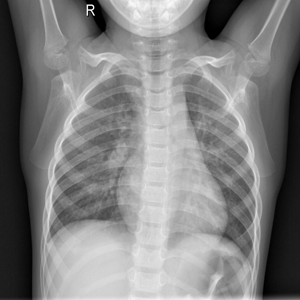

In [10]:
test_image = samples[0]['image']
label = "Pneumonia" if samples[0].get('label', 0) == 1 else "Normal"

print(f"Ground Truth: {label}")
display(test_image.resize((300, 300)))

In [11]:
print("Running PrimaCare analysis...\n")
results = primacare.analyze_xray(
    test_image, 
    clinical_context="Adult patient with cough and fever"
)
print("\n✓ Analysis complete!")

Running PrimaCare analysis...

  [1/4] Classifying...


The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


  [2/4] Extracting findings...


The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


  [3/4] Generating differential...


The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


  [4/4] Generating recommendations...

✓ Analysis complete!


In [12]:
# Classification results
print("="*60)
print("CLASSIFICATION (MedSigLIP)")
print("="*60)
for label, prob in sorted(results['classification'].items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(prob * 25) + "░" * (25 - int(prob * 25))
    print(f"{label:25s} {bar} {prob*100:5.1f}%")

CLASSIFICATION (MedSigLIP)
pneumonia                 █████░░░░░░░░░░░░░░░░░░░░  23.0%
normal chest x-ray        █████░░░░░░░░░░░░░░░░░░░░  23.0%
pulmonary edema           ████░░░░░░░░░░░░░░░░░░░░░  17.2%
consolidation             ███░░░░░░░░░░░░░░░░░░░░░░  12.9%
cardiomegaly              ███░░░░░░░░░░░░░░░░░░░░░░  12.0%
pneumothorax              █░░░░░░░░░░░░░░░░░░░░░░░░   6.5%
pleural effusion          ░░░░░░░░░░░░░░░░░░░░░░░░░   2.3%
atelectasis               ░░░░░░░░░░░░░░░░░░░░░░░░░   1.6%
mass or nodule            ░░░░░░░░░░░░░░░░░░░░░░░░░   1.5%


In [13]:
print("="*60)
print("FINDINGS")
print("="*60)
print(results['findings'])

FINDINGS
Based on the chest X-ray provided, here are the findings:

**General:**

*   **Age:** The image appears to be of a child.
*   **Position:** The child is in a standard PA (posteroanterior) chest X-ray position.
*   **Bones:** The ribs, clavicles, and scapulae are visible.
*   **Heart:** The heart size appears within normal limits.
*   **Mediastinum:** The mediastinum (the space between the lungs containing the heart, great vessels, trachea, etc.) appears normal.
*   **Lungs:** The lungs are clear, with no obvious consolidation, pleural effusion, or pneumothorax.

**Specific Findings:**

*   **Increased Lung Markings:** There is increased prominence of the lung markings, particularly in the lower lung fields. This could be due to various factors, including mild pulmonary edema, atelectasis, or simply normal variation in children.
*   **No Obvious Consolidation:** There is no clear evidence of pneumonia or other consolidation.
*   **No Pleural Effusion:** There is no visible pleu

In [14]:
print("="*60)
print("DIFFERENTIAL DIAGNOSIS")
print("="*60)
print(results['differential'])

DIFFERENTIAL DIAGNOSIS
Based on the chest X-ray provided, here are some potential differential diagnoses:

*   **Pneumonia:** The presence of patchy opacities in the lower lung fields could indicate pneumonia. The patient's symptoms of cough and fever support this possibility.
*   **Bronchiolitis:** This is a common viral infection in infants and young children, characterized by inflammation of the small airways in the lungs. The X-ray findings can include patchy opacities and peribronchial thickening.
*   **Viral Respiratory Infection:** Other viral infections can cause similar findings, such as influenza or RSV.
*   **Atypical Pneumonia:** Certain bacteria, such as Mycoplasma pneumoniae, can cause atypical pneumonia, which may present with patchy infiltrates.
*   **Heart Failure:** While less likely in this age group, heart failure can cause pulmonary edema, which may appear as increased interstitial markings and perihilar haziness on a chest X-ray.
*   **Asthma:** Asthma can cause a

In [15]:
print("="*60)
print("RECOMMENDATIONS")
print("="*60)
print(results['recommendations'])

RECOMMENDATIONS
Based on the chest X-ray, here's a breakdown of potential follow-up or workup recommendations:

**Key Observations:**

*   **Increased Lung Markings:** There appears to be increased opacity or increased markings in the lung fields, particularly in the lower lung zones. This could indicate a variety of conditions, including:
    *   **Infection:** Pneumonia (bacterial, viral, or fungal)
    *   **Inflammation:** Bronchitis, asthma exacerbation
    *   **Fluid:** Pulmonary edema (less likely in a child without other signs)
    *   **Other:** Interstitial lung disease, or other infiltrative processes.

*   **Heart Size:** The heart size appears to be within normal limits for a child.

*   **Bones:** The bones appear normal.

**Recommendations:**

1.  **Clinical Correlation:** The most important step is to correlate the X-ray findings with the patient's clinical presentation. What are the patient's symptoms? Fever, cough, shortness of breath, wheezing, or other respiratory 

## 7. Structured Report

In [16]:
print("Generating structured report...\n")
report = primacare.generate_report(
    test_image,
    patient_info={'age': '45', 'gender': 'Female', 'history': 'Cough x 1 week'}
)

print("="*60)
print("RADIOLOGY REPORT")
print("="*60)
print(report)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Generating structured report...

RADIOLOGY REPORT
FINDINGS:
The lungs are clear without focal consolidation, pleural effusion, or pneumothorax. The heart size is normal. The mediastinal contours are unremarkable. The visualized osseous structures are unremarkable. IMPRESSION:
No acute cardiopulmonary process.


## 8. Batch Test

Testing on multiple samples...


Sample 1 | Ground Truth: Normal


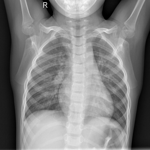

Top 3:
  pneumonia: 23.0%
  normal chest x-ray: 23.0%
  pulmonary edema: 17.2%

Sample 2 | Ground Truth: Normal


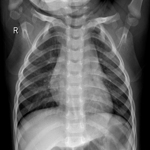

Top 3:
  normal chest x-ray: 30.2%
  cardiomegaly: 17.1%
  pneumonia: 15.8%

Sample 3 | Ground Truth: Normal


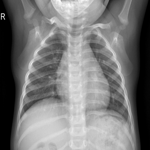

Top 3:
  normal chest x-ray: 41.3%
  cardiomegaly: 21.7%
  pneumonia: 11.0%


In [17]:
print("Testing on multiple samples...\n")

for i, sample in enumerate(samples):
    label = "Pneumonia" if sample.get('label', 0) == 1 else "Normal"
    
    print(f"\n{'='*50}")
    print(f"Sample {i+1} | Ground Truth: {label}")
    print("="*50)
    
    display(sample['image'].resize((150, 150)))
    
    # Quick classification
    probs = classify_image(sample['image'], primacare.CXR_LABELS)
    top = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3:")
    for lbl, prob in top:
        print(f"  {lbl}: {prob*100:.1f}%")

## 9. Summary

In [18]:
print("""
========================================
PRIMACARE AI - PROTOTYPE SUMMARY
========================================

✓ MedGemma 1.5 4B - Image analysis
✓ MedSigLIP - Zero-shot classification
✓ Full analysis pipeline
✓ Structured report generation

Next: Run 04_agentic_workflow.ipynb
for the multi-agent demo.
""")


PRIMACARE AI - PROTOTYPE SUMMARY

✓ MedGemma 1.5 4B - Image analysis
✓ MedSigLIP - Zero-shot classification
✓ Full analysis pipeline
✓ Structured report generation

Next: Run 04_agentic_workflow.ipynb
for the multi-agent demo.

